## a-AlphaBio homework 
### misc. futzing about.... prob messy

In [1]:
%load_ext autoreload

In [2]:
%autoreload
# import libraries
import numpy as np
import pickle as pk
import pandas as pd
import math
import os
import yaml
import sys
sys.path.append('/Users/markthompson/Documents/dev/a-alphaBio-homework/datasets/') 
print(sys.path)

import matplotlib.pyplot as plt
%matplotlib inline

['/home/mark/dev/aAlphaBio-Homework/notebooks', '/home/mark/anaconda3/envs/avm-dvm/lib/python39.zip', '/home/mark/anaconda3/envs/avm-dvm/lib/python3.9', '/home/mark/anaconda3/envs/avm-dvm/lib/python3.9/lib-dynload', '', '/home/mark/anaconda3/envs/avm-dvm/lib/python3.9/site-packages', '/Users/markthompson/Documents/dev/a-alphaBio-homework/datasets/']


In [3]:
import torch
num_patches = 144
dim = 128
a = torch.randn(1, num_patches + 1, dim)
print(a.shape)

torch.Size([1, 145, 128])


In [4]:
# Read the config
config_path = '../config/vit_params.yaml'
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

config = config['model_params']
print(config)


{'block_size': 288, 'mask_prob': 0.0, 'image_shape': [48, 48], 'patch_dim': 4, 'num_heads': 8, 'num_layers': 6, 'dim': 128, 'dropout': 0.3, 'accelerator': 'mps', 'devices': 1, 'batch_size': 512, 'num_workers': 10, 'grad_norm_clip': 1.0, 'num_epochs': 1000, 'log_dir': './lightning_logs/vit_model/cleaned-2/', 'train_data_path': '../data/train_set.csv', 'test_data_path': 'None', 'inference_data_path': '/Users/markthompson/Documents/dev/a-alphaBio-homework/data/q_cleaned_2_val_set.csv', 'checkpoint_name': '/Users/markthompson/Documents/dev/a-alphaBio-homework/lightning_logs/vit_model/cleaned-2/trained/checkpoints/epoch=836-step=18400.ckpt', 'learning_rate': 0.0001, 'lr_gamma': 0.999, 'betas': [0.9, 0.95], 'checkpoint_every_n_train_steps': 100, 'save_top_k': 4, 'monitor': 'val_loss', 'mode': 'min', 'log_every_nsteps': 10, 'inference_results_folder': './inference_results/vit/cleaned-2/', 'seed': 3407}


In [5]:
import math
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

#--------------------------------------------------------
# Code fragments taken from:
# * https://github.com/barneyhill/minBERT
# * https://github.com/karpathy/minGPT

# protein sequence data taken from:
# * https://www.nature.com/articles/s41467-023-39022-2
# * https://zenodo.org/records/7783546
#--------------------------------------------------------

class scFv_Dataset(Dataset):
    """
    Emits batches of amino acid sequences and binding energies
    """
    def __init__(self, config, csv_file_path, skiprows=0, inference=False):  
        super().__init__()
        self.config = config
        self.inference = inference
        print('reading the data from:', csv_file_path)
        self.df = pd.read_csv(csv_file_path, skiprows=skiprows)
        
        # 20 naturally occuring amino acids in human proteins plus MASK token, 
        # 'X' is a special token for unknown amino acids, and CLS token is for classification, and PAD for padding
        self.chars = ['CLS', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'MASK', 'PAD']
        print('vocabulary:', self.chars)

        data_size, vocab_size = self.df.shape[0], len(self.chars)
        print('data has %d rows, %d vocab size (unique).' % (data_size, vocab_size))

        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }
        self.vocab_size = vocab_size

    def get_vocab_size(self):
        return self.vocab_size

    def get_block_size(self):
        return self.config['block_size']

    def __len__(self):
        return self.df.shape[0] #len(self.data) - self.config['block_size']

    """ Returns data, mask pairs used for Masked Language Model training """
    def __getitem__(self, idx):
        seq = self.df.loc[idx, 'sequence_a']
        affinity = self.df.loc[idx, 'Kd'] if self.inference == False else 0.0
        assert not math.isnan(affinity), 'affinity is nan'
        assert affinity >= 0.0, 'affinity cannot be negative'

        # get a randomly located block_size-1 substring from the sequence
        # '-1' so we can prepend the CLS token to the start of the encoded string
        if len(seq) <= self.config['block_size']-1:
            chunk = seq
        else:
            start_idx = np.random.randint(0, len(seq) - (self.config['block_size'] - 1))
            chunk = seq[start_idx:start_idx + self.config['block_size']-1]

        # print('chunk length:', len(chunk), ', chunk:', chunk)

        # encode every character to an integer
        dix = torch.tensor([self.stoi[s] for s in chunk], dtype=torch.long)

        # prepend the CLS token to the sequence
        dix = torch.cat((torch.tensor([self.stoi['CLS']], dtype=torch.long), dix))

        # pad the end with PAD tokens if necessary
        first_aa = 1 # first aa position in the sequence (after CLS)
        last_aa = dix.shape[0] # last aa position in the sequence
        # print('first_aa:', first_aa, ', last_aa:', last_aa)
        if dix.shape[0] < self.config['block_size']:
            dix = torch.cat((dix, torch.tensor([self.stoi['PAD']] * (self.config['block_size'] - len(dix)), dtype=torch.long)))

        mask = None
        if self.config['mask_prob'] > 0:
            # dix looks like: [[CLS], x1, x2, x3, ..., xN, [PAD], [PAD], ..., [PAD]]
            # Never mask CLS or PAD tokens

            # get number of tokens to mask
            n_pred = max(1, int(round((last_aa - first_aa)*self.config['mask_prob'])))

            # indices of the tokens that will be masked (a random selection of n_pred of the tokens)
            masked_idx = torch.randperm(last_aa-1, dtype=torch.long, )[:n_pred]
            masked_idx += 1  # so we never mask the CLS token

            mask = torch.zeros_like(dix)

            # copy the actual tokens to the mask
            mask[masked_idx] = dix[masked_idx]
            
            # ... and overwrite them with MASK token in the data
            dix[masked_idx] = self.stoi['MASK']

        return dix, torch.tensor([affinity], dtype=torch.float32) 


In [51]:
import math
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
# from datasets.scFv_dataset import scFv_Dataset

#--------------------------------------------------------
# Simple wrapper Dataset to turn output from the scFv dataset
# into a B&W image for use in a CNN model
#--------------------------------------------------------
class CNN_Dataset(Dataset):
    """
    Emits 2D B&W images and binding energies
    """
    def __init__(self, config, csv_file_path, skiprows=0, inference=False):  
        super().__init__()
        self.scFv_dataset = scFv_Dataset(config, csv_file_path, skiprows, inference)
        self.config = config
        self.img_shape = config['image_shape']
         
        chars = self.scFv_dataset.chars
        groups= ['none', 'nonpolar', 'nonpolar', 'neg', 'neg', 'nonpolar', 'nonpolar', 'pos', 'nonpolar', 'pos', 'nonpolar', 'nonpolar', 'neg', 
                'nonpolar', 'neg', 'pos', 'polar', 'polar', 'nonpolar', 'nonpolar', 'polar', 'none', 'none', 'none']
        
        # for VIT, since the residue encodings are spread over 8-bits, assign encodings to groups that spread across the 8-bits
        group_encodings = { 'none'    : int('00101000', base=2), 
                            'polar'   : int('00110011', base=2),
                            'nonpolar': int('11001100', base=2), 
                            'pos'     : int('01010101', base=2),
                            'neg'     : int('10101010', base=2)} 

        # map encoded sequence to groups
        self.i_to_grp = {self.scFv_dataset.stoi[ch]:group_encodings[i] for ch,i in zip(chars, groups)} 
        print('i_to_grp:', self.i_to_grp)

        # The normalized frequence for each amino acid position in the scFv sequences over the entire clean_3 dataset
        # This fixed-array is 246 elements long.
        self.norm_mutation_freq = torch.tensor([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 
                            0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.95, 
                            0.95, 0.95, 0.95, 0.95, 0.95, 0.75, 0.9, 0.9, 0.95, 0.95, 0.95, 0.9, 0.95, 0.95, 0.85, 0.55,
                            0.5, 0.25, 0.35, 0.3, 0.6, 0.45, 0.55, 0.95, 0.8, 0.8, 0.8, 0.9, 0.75, 0.8, 0.6, 0.95, 0.85, 
                            0.35, 0.9, 0.85, 0.15, 0.4, 0.9, 0.3, 0.9, 0.8, 0.5, 0.95, 0.95, 0.95, 0.9, 0.6, 0.6, 0.75, 
                            0.3, 0.85, 0.4, 0.9, 0.95, 0.4, 0.9, 0.95, 0.9, 0.25, 0.75, 0.55, 0.85, 0.25, 0.75, 0.6, 0.65, 
                            0.8, 0.8, 0.95, 0.95, 0.85, 0.8, 0.8, 0.9, 0.7, 0.9, 0.9, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 
                            0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 
                            0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 
                            0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 
                            0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 
                            0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 
                            0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 
                            0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 
                            0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
                            0.05, 0.05, 0.05, 0.05])
        
        # promote values to 8-bit value range (255), then round up the norm_mutation_freq_encoded tensor and convert to long
        self.norm_mutation_freq_encoded = self.norm_mutation_freq * 255
        self.norm_mutation_freq_encoded = torch.round(self.norm_mutation_freq_encoded).to(torch.long)
        
    def get_vocab_size(self):
        return self.scFv_dataset.vocab_size

    def get_block_size(self):
        return self.config['block_size']

    def __len__(self):
        return self.scFv_dataset.__len__()

    def _bin(self, x):
        return format(x, '08b')

    def _encode_channel(self, x, shape=(48,48)):
        d = ''.join([self._bin(x[i]) for i in x.numpy()])
        # turn d into a list of integers, one for each bit
        d = [int(x) for x in d]    
        t = torch.tensor(d[:(shape[0]*shape[1])], dtype=torch.float32) # this is for 46,46 matrix
        t = t.reshape(shape)
        return t

    """ Returns image, kd pairs used for CNN training """
    def __getitem__(self, idx):
        dix, kd = self.scFv_dataset.__getitem__(idx)

        # The residue encoding channel
        ch_1 = self._encode_channel(dix, self.img_shape)

        # The residue group encoding channel
        dix_grp = torch.tensor([self.i_to_grp[i] for i in dix.numpy().tolist()], dtype=torch.long)
        ch_2 = self._encode_channel(dix_grp, self.img_shape)

        # The mutation frequency channel
        # anything not an amino acid gets a zero.
        ch3_in = torch.zeros_like(dix)
        # First aa is always position 1 (0 is a CLS token)
        ch3_in[1:len(self.norm_mutation_freq_encoded)+1] = self.norm_mutation_freq_encoded
        ch_3 = self._encode_channel(ch3_in)

        # stack the 3 channels into an bgr image
        bgr_img = torch.stack((ch_1, ch_2, ch_3), dim=0)

        return bgr_img, kd, ch_1, ch_2, ch_3

In [52]:
from torch.utils.data import DataLoader
# from datasets.scFv_dataset import scFv_Dataset as dataset

train_data_path = config['train_data_path']  
train_dataset = CNN_Dataset(config, train_data_path)
print(train_dataset.__len__())
config['vocab_size'] = train_dataset.get_vocab_size()
print('config[vocab_size]:', config['vocab_size'], ', config[block_size]:', config['block_size'])

train_loader = DataLoader(train_dataset, shuffle=True, pin_memory=True, batch_size=config['batch_size'], num_workers=config['num_workers'])


reading the data from: ../data/train_set.csv
vocabulary: ['CLS', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'MASK', 'PAD']
data has 26279 rows, 24 vocab size (unique).
i_to_grp: {0: 40, 1: 204, 2: 204, 3: 170, 4: 170, 5: 204, 6: 204, 7: 85, 8: 204, 9: 85, 10: 204, 11: 204, 12: 170, 13: 204, 14: 170, 15: 85, 16: 51, 17: 51, 18: 204, 19: 204, 20: 51, 21: 40, 22: 40, 23: 40}
26279
config[vocab_size]: 24 , config[block_size]: 288


torch.float32
img shape: torch.Size([3, 48, 48]) , kd: tensor([3.7660])


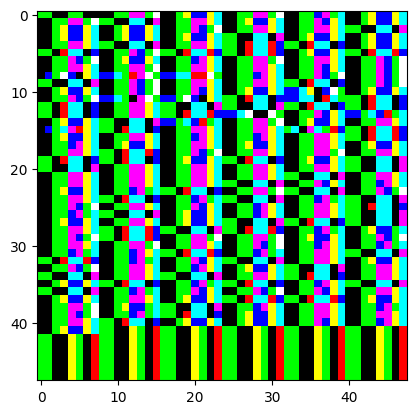

In [58]:
img, kd, ch_1, ch_2, ch_3 = train_dataset.__getitem__(105)
print(img.dtype)
# change the order of the channels to be (H, W) instead of (C, H, W)
rgb_img = img.permute(1, 2, 0)

print('img shape:', img.shape, ', kd:', kd)
plt.imshow(rgb_img) #, cmap='gray')

# plt.imshow(ch_3, cmap='gray')

----
### Examine other data that may be added as input channels to Vision Transformer.


In [ ]:
# Classify the amino acids into their usual groups
# polar, nonpolar, positively charged, negatively charged, or none (i.e. CLS, SEP, PAD)
#
# 20 naturally occuring amino acids in human proteins plus MASK token, 
# 'X' is a special token for unknown amino acids, and CLS token is for classification, and PAD for padding
chars = ['CLS', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'MASK', 'PAD']
groups= ['none', 'nonpolar', 'nonpolar', 'neg', 'neg', 'nonpolar', 'nonpolar', 'pos', 'nonpolar', 'pos', 'nonpolar', 'nonpolar', 'neg', 
         'nonpolar', 'neg', 'pos', 'polar', 'polar', 'nonpolar', 'nonpolar', 'polar', 'none', 'none', 'none']
print('\nvocabulary:', chars)

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

# for VIT, since the residue encodings are spread over 8-bits, assign encodings to groups that spread across the 8-bits
group_encodings = { 'none'    : int('00101000', base=2), 
                    'polar'   : int('00110011', base=2),
                    'nonpolar': int('11001100', base=2), 
                    'pos'     : int('01010101', base=2),
                    'neg'     : int('10101010', base=2)} 

print('group_encodings:', group_encodings)

# maps amino acid to group                     
s_to_grp = {ch:group_encodings[i] for ch,i in zip(chars, groups)} 
# maps encoded residue to group
i_to_grp = {stoi[ch]:group_encodings[i] for ch,i in zip(chars, groups)} 

print('\ns_to_grp:', s_to_grp)
print('\ni_to_grp:', i_to_grp)




In [ ]:
import torch
def _bin(x):
    return format(x, '08b')

def _encode_channel(x, shape=(48,48)):
    d = ''.join([_bin(x[i]) for i in x.numpy()])
    # turn d into a list of integers, one for each bit
    d = [int(x) for x in d]    
    t = torch.tensor(d[:(shape[0]*shape[1])], dtype=torch.float32) # this is for 46,46 matrix
    t = t.reshape(shape)
    # t = t.unsqueeze(0) # add channel dimension
    return t


In [ ]:
# Make a heat-map for the variability of each position in the sequence?
# That somehow changes with each sequence?
#